# LTO

We use LTO experimental data form a paper by [He](https://doi.org/10.1016/j.jallcom.2012.06.044).

## Data visualization

First we import the libraries that we will use throughout this example, this part is not strictly necessary to use **galpynostatic**

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

We load the data for the Li/Ti ratio of $0.8$ and the $C_{rates}$ used

In [2]:
C_rates = [0.1, 0.5, 1, 2, 5]
dataframes = [pd.read_csv(f"data/he/{crate}C.csv", header=None) for crate in C_rates]

we also define the equilibrium and cut-off potentials.

In [3]:
eq_pot = 1.57
vcut = 0.15

We plot the curves for visualization, with the corresponding potentials as dashed horizontal lines.

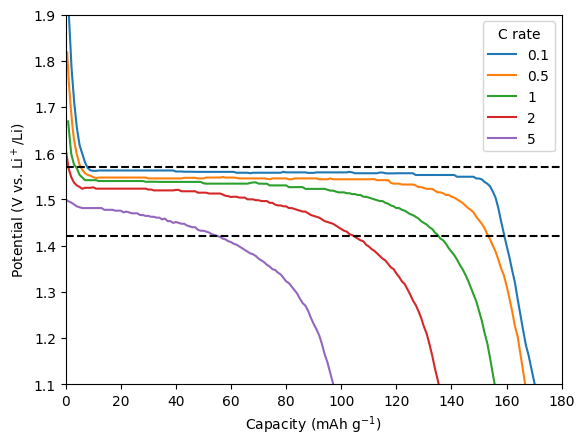

In [4]:
fig, ax = plt.subplots()

for crate, df in zip(C_rates, dataframes):
    ax.plot(df[0], df[1], label=f"{crate}")

ax.axhline(y=eq_pot, color="k", linestyle="--")
ax.axhline(y=eq_pot - vcut, color="k", linestyle="--")

ax.set_xlim((0, 180))
ax.set_ylim((1.1, 1.9))
ax.set_xlabel(r"Capacity (mAh g$^{-1}$)")
ax.set_ylabel(r"Potential (V vs. Li$^+$/Li)")
ax.legend(title="C rate")
plt.show()

## Preprocessing

We can use the `preprocessing` module of `galpynostatic` to obtain the discharge capacitites.

In [5]:
import galpynostatic

In [6]:
gdc = galpynostatic.preprocessing.GetDischargeCapacities(eq_pot)
xmaxs = gdc.fit_transform(dataframes)

And we normalize these currents by the maximum value we define

In [7]:
soc = xmaxs / 160

And we visualize the data we are going to use to adjust

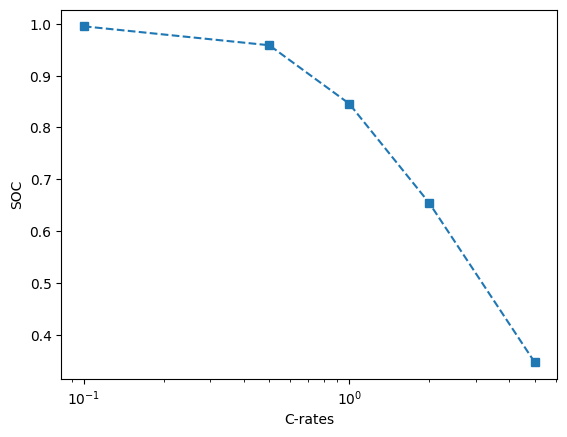

In [8]:
plt.plot(C_rates, soc, marker="s", ls="--")

plt.xlabel("C-rates")
plt.ylabel("SOC")
plt.xscale("log")
plt.show()

## Fitting

In the work it is mentioned that the particle sizes are distributed between $0.5-3 \mu m$, we take the midpoint as a first approximation.

In [9]:
d = 0.000175

We load the surface data for spherical geometry

In [10]:
dataset = galpynostatic.datasets.load_spherical()

And we fit on it

In [11]:
greg = galpynostatic.model.GalvanostaticRegressor(dataset, d, 3)

C_rates = np.array(C_rates).reshape(-1, 1)
greg.fit(C_rates, soc)

## Results

We can start by knowing the values obtained for the diffusion coefficient and the kinetic rate constant. 

In [12]:
print(f"Diffusion coefficient: {greg.dcoeff_:.3e} cm^2/s")
print(f"Kinetic rate constant: {greg.k0_:.3e} cm/s")

Diffusion coefficient: 6.579e-12 cm^2/s
Kinetic rate constant: 8.111e-08 cm/s


While the diffusion coefficient reported in this work, for this Li/Ti ratio, is $5.12\times10^{-12} cm^2/s$.

with a mean square error for the model of

In [13]:
print(f"{greg.mse_:.6f}")

0.000634


We can estimate the optimal value for the characteristic length of the nanoparticle, i.e. the size to obtain 80% of the charge in 5 minutes.

In [14]:
new_d = galpynostatic.predict.t_minutes_length(greg)
print(f"{new_d:.6f} micrometers")

0.528492 micrometers


We plot data versus predictions

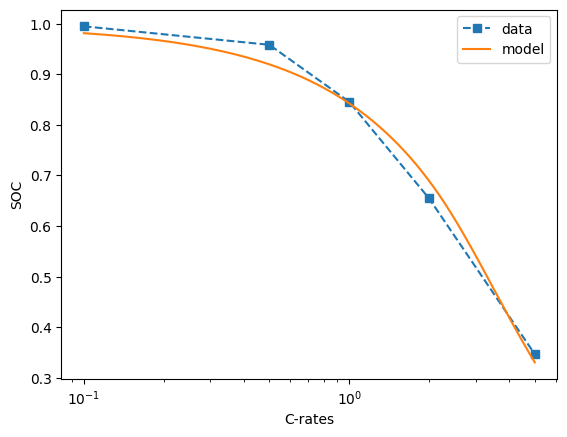

In [15]:
greg.plot.versus_data(C_rates, soc)

plt.legend()
plt.show()

Finally, we can observe the region of the map where these results are found

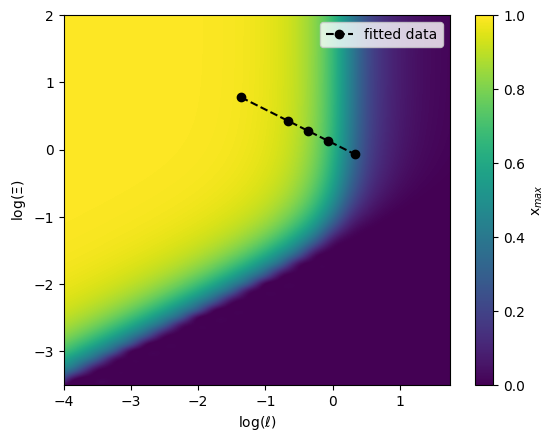

In [16]:
greg.plot.in_surface(C_rates)
plt.legend()
plt.show()